In [0]:
import numpy as np
import os
from os.path import isfile
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, TimeDistributed, LSTM, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D,MaxPooling2D, Flatten, Conv2D, BatchNormalization, Lambda, Reshape
from keras.layers.advanced_activations import ELU
from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau, EarlyStopping
from keras import backend
from keras.utils import np_utils
from keras.optimizers import Adam, RMSprop

from keras import regularizers


import librosa
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline

In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
cd drive/"My Drive"/FMA_Music

[Errno 2] No such file or directory: 'drive/My Drive/FMA_Music'
/content/drive/My Drive/FMA_Music


### Load training and Validation arrays

In [44]:
dict_genres = {'Electronic':0,  'Folk':1,  'Pop' :2, 'Instrumental':3 }

reverse_map = {v: k for k, v in dict_genres.items()}
print(reverse_map)

{0: 'Electronic', 1: 'Folk', 2: 'Pop', 3: 'Instrumental'}


In [45]:
npzfile = np.load('loaddata/suf_train_arr30.npz')
print(npzfile.files)
X_train = npzfile['arr_0']
y_train = npzfile['arr_1']
print(X_train.shape, y_train.shape)

['arr_0', 'arr_1']
(9597, 420, 128) (9597,)


In [46]:
npzfile = np.load('loaddata/suf_valid_arr30.npz')
print(npzfile.files)
X_valid = npzfile['arr_0']
y_valid = npzfile['arr_1']
print(X_valid.shape, y_valid.shape)

['arr_0', 'arr_1']
(1200, 420, 128) (1200,)


In [0]:
y_train = np_utils.to_categorical(y_train)
y_valid = np_utils.to_categorical(y_valid)

In [0]:
X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]

### CNN Model

In [49]:
freq=128
timeframe=420
input_shape=(timeframe, freq, 1)
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(4, activation='softmax'))

opt=keras.optimizers.Adam(lr=0.0005)

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=opt,
              metrics=['accuracy'])

print(model.summary())

checkpoint_callback = ModelCheckpoint('./models/cnn/weights.best.h5', monitor='val_acc', verbose=1,
                                          save_best_only=True, mode='max')



earlyStopping = EarlyStopping(monitor='val_acc', patience=25, verbose=1, mode='max')
    
reducelr_callback = ReduceLROnPlateau(
                monitor='val_acc', factor=0.5, patience=10, min_delta=0.01,
                verbose=1
            )
callbacks_list = [earlyStopping,checkpoint_callback, reducelr_callback]


history=model.fit(X_train, y_train,
          batch_size=32,
          epochs=70,
          verbose=1,
          validation_data=(X_valid, y_valid),callbacks=callbacks_list)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 418, 126, 32)      320       
_________________________________________________________________
batch_normalization_6 (Batch (None, 418, 126, 32)      128       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 209, 63, 32)       0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 209, 63, 32)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 207, 61, 32)       9248      
_________________________________________________________________
batch_normalization_7 (Batch (None, 207, 61, 32)       128       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 103, 30, 32)       0         
__________

In [0]:
def show_summary_stats(history):
    # List all data in history
    print(history.history.keys())

    # Summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


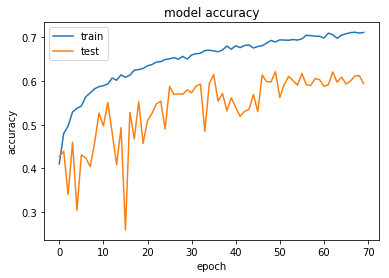

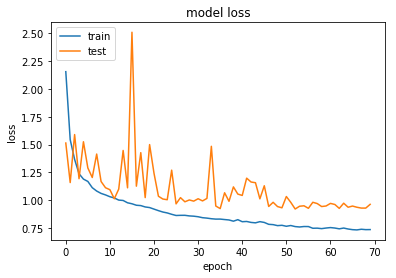

In [51]:
show_summary_stats(history)

In [52]:
from sklearn.metrics import classification_report

y_true = np.argmax(y_valid, axis = 1)
y_pred = model.predict(X_valid)
y_pred = np.argmax(y_pred, axis=1)
labels = [0,1,2,3]
target_names = dict_genres.keys()

print(y_true.shape, y_pred.shape)
print(classification_report(y_true, y_pred, target_names=target_names))

(1200,) (1200,)
              precision    recall  f1-score   support

  Electronic       0.71      0.71      0.71       300
        Folk       0.80      0.49      0.61       300
         Pop       0.44      0.41      0.43       300
Instrumental       0.52      0.76      0.62       300

    accuracy                           0.59      1200
   macro avg       0.62      0.59      0.59      1200
weighted avg       0.62      0.59      0.59      1200



In [53]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_true, y_pred))

0.5941666666666666


### Connect to Test Set

In [0]:
from keras.models import load_model

weights_path = 'models/cnn/weights.best.h5'
model = load_model(weights_path)

In [55]:
npzfile = np.load('loaddata/test_arr30.npz')
print(npzfile.files)
X_test = npzfile['arr_0']
y_test = npzfile['arr_1']
X_test = X_test[..., np.newaxis]
print(X_test.shape, y_test.shape)

['arr_0', 'arr_1']
(1200, 420, 128, 1) (1200,)


In [56]:
from sklearn.metrics import classification_report

y_true = y_test
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
labels = [0,1,2,3,4]
target_names = dict_genres.keys()

print(y_true.shape, y_pred.shape)
print(classification_report(y_true, y_pred, target_names=target_names))

(1200,) (1200,)
              precision    recall  f1-score   support

  Electronic       0.77      0.53      0.63       300
        Folk       0.38      0.28      0.33       300
         Pop       0.45      0.44      0.45       300
Instrumental       0.33      0.52      0.40       300

    accuracy                           0.44      1200
   macro avg       0.48      0.44      0.45      1200
weighted avg       0.48      0.44      0.45      1200



In [57]:
y_test = keras.utils.to_categorical(y_test, num_classes=4)
model.evaluate(X_test, y_test)

1200/1200 [==============================] - 2s 1ms/step


[1.2981020879745484, 0.44416666666666665]

In [58]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_true, y_pred))

[[158  13  23 106]
 [  1  85  91 123]
 [ 44  32 133  91]
 [  2  92  49 157]]


In [59]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_true, y_pred))

0.44416666666666665


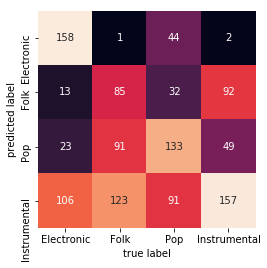

In [60]:
### 4 clusters
from sklearn.metrics import confusion_matrix
import seaborn as sns


mat = confusion_matrix(y_true, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=dict_genres.keys(),
            yticklabels=dict_genres.keys())
plt.xlabel('true label')
plt.ylabel('predicted label');
